GitHub: https://github.com/PriyaHockey/SIT799-Tasks


Welcome to your assignment this week! 

To better understand the adverse use of AI, in this assignment, we will look at a Natural Language Processing use case.


Natural Language Pocessing (NLP) is a branch of Artificial Intelligence (AI) that helps computers to understand, to interpret and to manipulate natural (i.e. human) language.
Imagine NLP-powered machines as black boxes that are capable of understanding and evaluating the context of the input documents (i.e. collection of words), outputting meaningful results that depend on the task the machine is designed for.


![](imgs/1_3zMvUnPzYZF9CSHdj6hT5A.png)

<caption><center> Documents are fed into magic NLP model capable to get, for instance, the sentiment of the original content</center></caption>


In this notebook, you will implement a model that uses an LSTM to generate fake tweets and comments. You will also be able to try it to generate your own fake text. 

**You will learn to:**
- Apply an LSTM to generate fake comments.
- Generate your own fake text with deep learning.

Please run the following cell to load all the packages required in this assignment. This may take a few minutes. 


In [ ]:
#!pip install numpy
#!pip install keras
#!pip install tensorflow

Run the following cell to load the packages you will need.

In [15]:
import time
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import tensorflow.keras.utils as ku 
import keras.backend as K
import matplotlib.pyplot as plt
import numpy as np


Using TensorFlow backend.


# Build the model

Let's define a tokenizer and read the data from disk.

In [260]:
tokenizer = Tokenizer(filters='"#$%&()*+-/:;<=>@[\\]^_`{|}~\t\n')
data = open('covid19_fake.txt').read().replace(".", " . ").replace(",", " , ").replace("?", " ? ").replace("!", " ! ")

Now, let's splits the data into tweets  where each line of the input file is a fake tweets.

We also extract the vocabulary of the data.

In [261]:
corpus = data.lower().split("\n")
tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

You've loaded:
- `corpus`: an array where each entry is a fake post.
- `tokenizer`: which is the object that we will use to vectorize our dataset. This object also contains our word index.
- `total_words`: is the total number of words in the vacabulary.


In [262]:
print("Example of fake tweets: ",corpus[:2])
print("Size of the vocabulary = ", total_words)
index = [(k, v) for k, v in tokenizer.word_index.items()]
print("Example of our word index = ", index[0:10])

Example of fake tweets:  ['there is already a vaccine to treat covid19 . ', 'cleaning hands do not help to prevent covid19 . ']
Size of the vocabulary =  1257
Example of our word index =  [('.', 1), ('the', 2), ('covid19', 3), ('in', 4), ('to', 5), ('a', 6), ('of', 7), (',', 8), ('coronavirus', 9), ('and', 10)]


The next step aims to generate the training set of n_grams sequences.

In [263]:
input_sequences = []
for line in corpus:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

You've create:
- `input_sequences`: which is a list of n_grams sequences.

In [264]:
sample = 20
reverse_word_map = dict(map(reversed, tokenizer.word_index.items()))
print("The entry ",sample," in 'input_sequences' is: ")
print(input_sequences[sample])
print(" and it corresponds to:")
for i in input_sequences[sample]:
    print(reverse_word_map[i], end=' ')
                        

The entry  20  in 'input_sequences' is: 
[2, 3, 12, 187, 34, 188]
 and it corresponds to:
the covid19 is same as sars 

Next, we padd our training set to the max length in order to be able to make a batch processing.

In [265]:
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

Run the following to see the containt of the padded 'input_sequences' object.

In [266]:
reverse_word_map = dict(map(reversed, tokenizer.word_index.items()))
print("The entry ",sample," in 'input_sequences' is: ")
print(input_sequences[sample])
print(" and it corresponds to:")
print("[", end=' ')
for i in input_sequences[sample]:
    if i in reverse_word_map:
        print(reverse_word_map[i], end=' ')
    else:
        print("__", end=' ')
print("]")
                

The entry  20  in 'input_sequences' is: 
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   2   3  12 187  34 188]
 and it corresponds to:
[ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ the covid19 is same as sars ]


Given a sentence like **"the covid19 is same as "**, we want to design a model that can predict the next word -- in the case the word **"sars"**.

Therefore, the next code prepares our input and output to our model consequently.

In [267]:
input_to_model, label = input_sequences[:,:-1],input_sequences[:,-1]


In [268]:
print("The entry ",sample," in 'input_sequences' is: ")
print(input_sequences[sample])
print(", it corresponds to the following input to our model:")
print(input_to_model[sample])
print(" and the following output: ", label[sample])


The entry  20  in 'input_sequences' is: 
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   2   3  12 187  34 188]
, it corresponds to the following input to our model:
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   2   3  12 187  34]
 and the following output:  188


Finally, we convert our label to categorical labels for being processed by our model.

In [269]:
label = ku.to_categorical(label, num_classes=total_words)

Here is the architecture of the model we will use:

![](imgs/text_generation.png)



 
**Task 1**: Implement `deep_fake_comment_model()`. You will need to carry out 5 steps:

1. Create a sequencial model using the `Sequential` class
2. Add an embedding layer to the model using the `Embedding` class of size 128
3. Add an LSTM layer to the model using the `LSTM` class of size 128
4. Add a Dense layer to the model using the `Dense` class with a `softmax` activation
5. Set a `categorical_crossentropy` loss function to the model and optimize `accuracy`.


In [270]:
#TASK 1
# deep_fake_comment_model
import keras
import tensorflow as tf
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from tensorflow.keras import layers


def deep_fake_comment_model():
    model = keras.models.Sequential()
    model.add(keras.layers.Embedding(input_dim=1500, output_dim=128))
    model.add(keras.layers.LSTM(128))
    model.add(keras.layers.Dropout(0.3))
    model.add(keras.layers.Dense(total_words, activation = 'softmax'))
    model.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])
    
    return model
#Print details of the model.
model = deep_fake_comment_model()
print(model.summary())

Model: "sequential_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_48 (Embedding)     (None, None, 128)         192000    
_________________________________________________________________
lstm_48 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dropout_16 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_47 (Dense)             (None, 1257)              162153    
Total params: 485,737
Trainable params: 485,737
Non-trainable params: 0
_________________________________________________________________
None


Now, let's start our training.

In [271]:
from sklearn import preprocessing
history = model.fit(input_to_model, label, epochs=20, batch_size=32, verbose=1)

Epoch 1/20
4030/4030 [==============================] - 72s 18ms/step - loss: 6.3451 - accuracy: 0.0573
Epoch 2/20
4030/4030 [==============================] - 57s 14ms/step - loss: 5.8961 - accuracy: 0.0749
Epoch 3/20
4030/4030 [==============================] - 50s 12ms/step - loss: 5.7602 - accuracy: 0.0809
Epoch 4/20
4030/4030 [==============================] - 50s 12ms/step - loss: 5.6276 - accuracy: 0.1087
Epoch 5/20
4030/4030 [==============================] - 56s 14ms/step - loss: 5.4679 - accuracy: 0.1251
Epoch 6/20
4030/4030 [==============================] - 64s 16ms/step - loss: 5.2996 - accuracy: 0.1385
Epoch 7/20
4030/4030 [==============================] - 54s 13ms/step - loss: 5.1315 - accuracy: 0.1514
Epoch 8/20
4030/4030 [==============================] - 48s 12ms/step - loss: 4.9743 - accuracy: 0.1628
Epoch 9/20
4030/4030 [==============================] - 59s 15ms/step - loss: 4.8043 - accuracy: 0.1717
Epoch 10/20
4030/4030 [==============================] - 51s 13m

Let's plot details of our training.

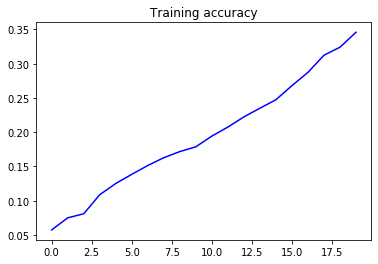

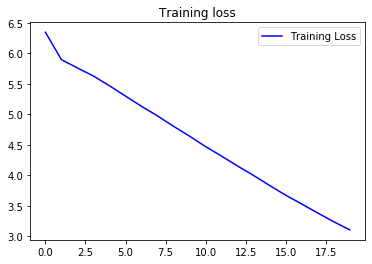

In [272]:
acc = history.history['accuracy']
loss = history.history['loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')
plt.figure()
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()
plt.show()

# Generating fake comments

To generate fake tweets, we use the below architecture:

![](imgs/text_gen.png)

The idea is to give one or more starting token(s) to our model, and generate the next tokens until we generate `.`.

At each step, we select the token with the highest probability as our next token and generate the next one similartly using `model.predict_classes()`. 

**Note:** The model takes as input the activation `a` from the previous state of the LSTM and the token chosen, forward propagate by one step, and get a new output activation `a`. The new activation `a` can then be used to generate the output, using the `dense` layer with `softmax` activation as before. 



**Task 2**: Implement `generate()`. 

***

In [276]:
#TASK 2
# Implement the generate() function
def generate(seed_text):
    in_text = seed_text
    print(in_text)
    encoded = tokenizer.texts_to_sequences([in_text])
    encoded = np.array(encoded)
    yhat = model.predict_classes(encoded, verbose=0)
    for word, index in tokenizer.word_index.items():
        if index == yhat:
            return(word)

model = keras.models.Sequential()
model.add(keras.layers.Embedding(input_dim=1500, output_dim=128))
model.add(keras.layers.LSTM(128))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Dense(total_words, activation = 'softmax'))
model.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])

# compile network
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


            

**Let's test it:**

In [277]:
print(generate("COVID19 virus"))
print(generate("COVID19 is the"))
print(generate("The usa is"))
print(generate("The new virus"))
print(generate("China has"))


COVID19 virus
gainesville
COVID19 is the
eyes
The usa is
immediate
The new virus
uk
China has
beach


**Let's test it in an interactive mode:**

In [282]:
usr_input = input("Write the beginning of your tweet, the algorithm machine will complete it. Your input is: ")
for w in generate(usr_input).split():    
    print(w, end =" ")
    time.sleep(0.4)


Write the beginning of your tweet, the algorithm machine will complete it. Your input is: Cleaning hands do
Cleaning hands do
exotic 

# Generating text by sampling

The previous part is generating text by choosing the token with the highest probability. Now, we sill generate text by sampling as shown in the architecture below:

![](imgs/text_gen_sample.png)


**TASK 3:** Implement the `generate_sample()` function. To sample a token from the output at each timestep, you need to use the following two functions:
- `model.predict_proba()`: To get probabilities from the output layer.
- `np.random.choice()`: To sample from the token list using the probaility array of each token.

***

In [286]:
#TASK 3
# Implement the generate_sample() function
def generate(seed_text):
    in_text = seed_text
    encoded = tokenizer.texts_to_sequences([in_text])
    encoded = np.array(encoded)
    
model = keras.models.Sequential()
model.add(keras.layers.Embedding(input_dim=1500, output_dim=128))
model.add(keras.layers.LSTM(128))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Dense(total_words, activation = 'softmax'))
model.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])
model.predict_proba(encoded, verbose=0)
np.random.choice

# compile network
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    
  

**Let's test it in an interactive mode:**

In [ ]:
usr_input = input("Write the beginning of your tweet, the algorithm machine will complete it. Your input is: ")
for w in generate_sample(usr_input).split():    
    print(w, end =" ")
    time.sleep(0.4)


# Generate your own text 

Below, use you own data to generate content for a different application:

In [237]:
tokenizer = Tokenizer(filters='"#$%&()*+-/:;<=>@[\\]^_`{|}~\t\n')
data = """During the Renaissance, artist were no longer regarded as mere artisans, as they had been to the medieval past, 
        but for the first time emerged as independent personalities, compared to poets and writers. 
        Many artisans merged mathematics with art, in order to become more precise in their measurements and to make sure
        an object was supported both rationally and proportionally. However, Renaissance artists also placed human concerns 
        and feelings at the center of their works. Such optimism combined with intellectual curiosity and increasing 
        worldliness made it possible for art to be valued. Over all, the Renaissance art movement completely discredited 
        the middle Ages as being dead both intellectually and artistically, thus rendering the Byzantine, Romanesque, 
        and Gothic style art as being without value. The Renaissance came from a revival of the Classical ideas, concepts, 
        and knowledge.  What had once been forgotten was once again the focus of society.  It was also found that in 
        Classical times artists enjoyed a much higher level of prestige than they did during the Middle Ages.  Artists 
        wanted to enjoy this status once again."""

In [238]:
corpus = data.lower().split("\n")
tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

In [239]:
print("Example of fake sentences: ",corpus[:2])
print("Size of the vocabulary = ", total_words)
index = [(k, v) for k, v in tokenizer.word_index.items()]
print("Example of our word index = ", index[0:10])

Example of fake sentences:  ['during the renaissance, artist were no longer regarded as mere artisans, as they had been to the medieval past, ', '        but for the first time emerged as independent personalities, compared to poets and writers. ']
Size of the vocabulary =  125
Example of our word index =  [('the', 1), ('and', 2), ('to', 3), ('as', 4), ('of', 5), ('in', 6), ('was', 7), ('renaissance', 8), ('artists', 9), ('art', 10)]


In [240]:
input_sequences = []
for line in corpus:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

In [241]:
sample = 20
reverse_word_map = dict(map(reversed, tokenizer.word_index.items()))
print("The entry ",sample," in 'input_sequences' is: ")
print(input_sequences[sample])
print(" and it corresponds to:")
for i in input_sequences[sample]:
    print(reverse_word_map[i], end=' ')
                        

The entry  20  in 'input_sequences' is: 
[36, 16, 1, 37]
 and it corresponds to:
but for the first 

In [242]:
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

In [243]:
reverse_word_map = dict(map(reversed, tokenizer.word_index.items()))
print("The entry ",sample," in 'input_sequences' is: ")
print(input_sequences[sample])
print(" and it corresponds to:")
print("[", end=' ')
for i in input_sequences[sample]:
    if i in reverse_word_map:
        print(reverse_word_map[i], end=' ')
    else:
        print("__", end=' ')
print("]")
            

The entry  20  in 'input_sequences' is: 
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 36 16  1 37]
 and it corresponds to:
[ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ but for the first ]


In [244]:
input_to_model, label = input_sequences[:,:-1],input_sequences[:,-1]

In [245]:
print("The entry ",sample," in 'input_sequences' is: ")
print(input_sequences[sample])
print(", it corresponds to the following input to our model:")
print(input_to_model[sample])
print(" and the following output: ", label[sample])

The entry  20  in 'input_sequences' is: 
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 36 16  1 37]
, it corresponds to the following input to our model:
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 36 16  1]
 and the following output:  37


In [246]:
label = ku.to_categorical(label, num_classes=total_words)

In [247]:
import keras
import tensorflow as tf
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from tensorflow.keras import layers


def deep_fake_comment_model():
    model = keras.models.Sequential()
    model.add(keras.layers.Embedding(input_dim=1500, output_dim=128))
    model.add(keras.layers.LSTM(128))
    model.add(keras.layers.Dropout(0.3))
    model.add(keras.layers.Dense(total_words, activation = 'softmax'))
    model.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])
    
    return model
#Print details of the model.
model = deep_fake_comment_model()
print(model.summary())

Model: "sequential_46"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_44 (Embedding)     (None, None, 128)         192000    
_________________________________________________________________
lstm_44 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dropout_12 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_43 (Dense)             (None, 125)               16125     
Total params: 339,709
Trainable params: 339,709
Non-trainable params: 0
_________________________________________________________________
None


In [248]:
from sklearn import preprocessing
history = model.fit(input_to_model, label, epochs=20, batch_size=32, verbose=1)

Epoch 1/20
168/168 [==============================] - 10s 57ms/step - loss: 4.8300 - accuracy: 0.0000e+00
Epoch 2/20
168/168 [==============================] - 1s 6ms/step - loss: 4.8139 - accuracy: 0.0417
Epoch 3/20
168/168 [==============================] - 1s 5ms/step - loss: 4.7955 - accuracy: 0.0595
Epoch 4/20
168/168 [==============================] - 1s 5ms/step - loss: 4.7556 - accuracy: 0.0595
Epoch 5/20
168/168 [==============================] - 1s 6ms/step - loss: 4.7201 - accuracy: 0.0595
Epoch 6/20
168/168 [==============================] - 1s 5ms/step - loss: 4.6317 - accuracy: 0.0595
Epoch 7/20
168/168 [==============================] - 1s 5ms/step - loss: 4.6117 - accuracy: 0.0595
Epoch 8/20
168/168 [==============================] - 1s 5ms/step - loss: 4.5490 - accuracy: 0.0595
Epoch 9/20
168/168 [==============================] - 1s 5ms/step - loss: 4.5154 - accuracy: 0.0595
Epoch 10/20
168/168 [==============================] - 1s 5ms/step - loss: 4.4778 - accuracy: 

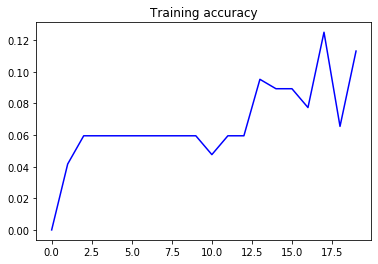

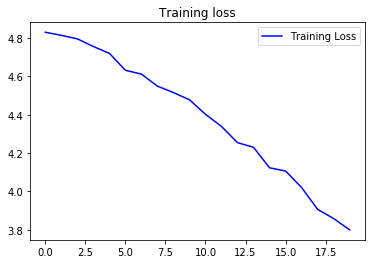

In [249]:
acc = history.history['accuracy']
loss = history.history['loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')
plt.figure()
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()
plt.show()

In [250]:
def generate(seed_text):
    in_text = seed_text
    print(in_text)
    encoded = tokenizer.texts_to_sequences([in_text])
    encoded = np.array(encoded)
    yhat = model.predict_classes(encoded, verbose=0)
    for word, index in tokenizer.word_index.items():
        if index == yhat:
            return(word)

model = keras.models.Sequential()
model.add(keras.layers.Embedding(input_dim=1500, output_dim=128))
model.add(keras.layers.LSTM(128))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Dense(total_words, activation = 'softmax'))
model.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])

# compile network
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [251]:
print(generate("artist were no"))
print(generate(" optimism combined with"))
print(generate("Early Renaissance"))
print(generate("Gothic style art"))

artist were no
did
 optimism combined with
intellectual
Early Renaissance
status
Gothic style art
rendering


In [254]:
usr_input = input("Write the sentence, the algorithm machine will complete it. Your input is: ")
for w in generate(usr_input).split():    
    print(w, end =" ")
    time.sleep(0.4)

Write the sentence, the algorithm machine will complete it. Your input is: the Renaissance art movement
the Renaissance art movement
prestige 

# Congratulations!

You've come to the end of this assignment, and have seen how to build a deep learning architecture that generate fake tweets/comments. 

Congratulations on finishing this notebook! 

